<a href="https://colab.research.google.com/github/joaochenriques/IST---Marine-Currents-and-Tidal-Energy/blob/main/Tidal_Stream/BladeElementMethod/BladeDesign_V07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import subprocess
import pandas as pd
import pathlib
import numpy as np
from scipy.optimize import minimize, root_scalar

def cmdcall( cmd, verbose = False ):
    output = subprocess.getoutput( cmd )
    if verbose: print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import matplotlib.pyplot as mpl
import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [109]:
class Data:

    def __init__( self, λ_hub, λ_tip, dλ ):
        n = int( ( λ_tip - λ_hub ) / dλ + 0.5 ) + 1
        self.n       = n
        self.λ_hub   = λ_hub
        self.λ_tip   = λ_tip
        self.λ_vec   = np.linspace( λ_hub, λ_tip, n )
        self.a_vec   = np.zeros( n )
        self.ap_vec  = np.zeros( n )
        self.ϕ_vec   = np.zeros( n )
        self.σCL_vec = np.zeros( n )
        self.CP_vec  = np.zeros( n )
        self.CP_tip  = 0.0

In [110]:
rad2deg = 180/np.pi
deg2rad = np.pi/180

_λ_hub = 1.4
_λ_tip = 7.0
_dλ = 0.2

dti = Data( _λ_hub, _λ_tip, _dλ ) # inviscid results
dtv = Data( _λ_hub, _λ_tip, _dλ ) # viscous results

## Glauert optimal distribution

C_P = 0.5608


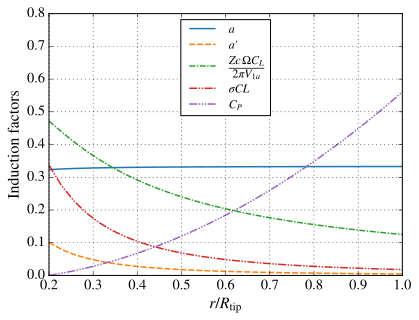

In [111]:
def f(y):
    return -64/5 * y**5 - 72 * y**4 - 124 * y**3 - 38 * y**2 + 63 * y + 12 * np.log(y) + 4 / y

def Integral_f( y2, y1, λ_tip ):
    return 8 / ( 729 * λ_tip**2 ) * ( f(y2) - f(y1) )

CP = 0

for i, λ in enumerate( dti.λ_vec ):

    func = lambda a: 16 * a**3 - 24 * a**2 + 3 * ( 3 - λ**2 ) * a + ( λ**2 - 1 )
    a = root_scalar(func, bracket=[ 1.0/4.0, 1.0/3.0 ], method='brentq' ).root
    ap = ( 1.0 - 3 * a ) / ( 4 * a - 1 )

    ϕ = np.arctan( ( 1 - a ) / ( 1 + ap ) / λ )
    σCL  = 4.0 * ap * λ / np.sqrt( ( 1.0 - a )**2 + ( 1.0 + ap )**2 * λ**2 )

    dti.a_vec[i] = a
    dti.ap_vec[i] = ap
    dti.ϕ_vec[i] = ϕ
    dti.σCL_vec[i] = σCL

    if i > 0:
        dti.CP_vec[i] = CP = CP + Integral_f( 1 - 3*dti.a_vec[i], 1 - 3*dti.a_vec[i-1], dti.λ_tip )
    else:
        CP = 0.0

x_vec = dti.λ_vec / dti.λ_tip

mpl.plot( x_vec, dti.a_vec,  label = r"$a$" )
mpl.plot( x_vec, dti.ap_vec, label = r"$a\prime$" )
mpl.plot( x_vec, dti.σCL_vec*dti.λ_vec, label = r"$\dfrac{Zc\,\Omega C_L}{2\pi V_{1a}}$" )
mpl.plot( x_vec, dti.σCL_vec, label = r"$\sigma CL$" )
mpl.plot( x_vec, dti.CP_vec, label = r"$C_P$" )

mpl.xlabel( r"$r/R_\mathrm{tip}$")
mpl.ylabel( "Induction factors")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()
mpl.ylim( ( 0.0, 0.8 ) )
mpl.savefig( "InductionFactors.pdf" )
print( f"C_P = {dti.CP_vec[-1]:.4f}" )

In [112]:
df = pd.DataFrame( { r"$\lambda$": dti.λ_vec,
                     r"$a$": dti.a_vec,
                     r"$a'$": dti.ap_vec,
                     r"$\phi$": dti.ϕ_vec*rad2deg,
                     r"$C_P$": dti.CP_vec,
                     r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$": dti.σCL_vec*dti.λ_vec,
                     r"$\sigma C_L$": dti.σCL_vec
                    } )

# print( df.to_latex(index=False,
#        formatters=["{:.2f}".format,"{:.5f}".format,"{:.5f}".format, \
#                    "{:.2f}".format,"{:.3f}".format,"{:.4f}".format]
# ))
df

,$\lambda$,$a$,$a'$,$\phi$,$C_P$,"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$",$\sigma C_L$
0,1.4,0.323411,0.101366,23.691785,0.000000,0.471967,0.337119
1,1.6,0.325353,0.079432,21.336922,0.006657,0.438676,0.274172
2,1.8,0.326798,0.063828,19.369736,0.014332,0.407535,0.226408
3,2.0,0.327896,0.052354,17.710034,0.023020,0.379134,0.189567
4,2.2,0.328747,0.043685,16.295970,0.032714,0.353540,0.160700
5,2.4,0.329417,0.036983,15.079910,0.043410,0.330586,0.137744
6,2.6,0.329954,0.031700,14.025007,0.055102,0.310024,0.119240
7,2.8,0.330390,0.027464,13.102549,0.067789,0.291582,0.104136
8,3.0,0.330747,0.024018,12.289966,0.081466,0.275006,0.091669
9,3.2,0.331045,0.021178,11.569350,0.096131,0.260062,0.081269


## Computing the turbine blade (Glauert's solution)

In [113]:
def airfoil_data( α, Wm = None ):
    α *= rad2deg
    # CL = 0.368 + 0.094 * α
    # CD = 0.00994 + 0.000259 * α + 0.0001055 * α**2
    CL = 0.953
    CD = 0.00512
    return CL, CD

In [114]:
Z = 3
α  = 6.09 * deg2rad
CL, CD = airfoil_data( α )
CL, CD

(0.953, 0.00512)

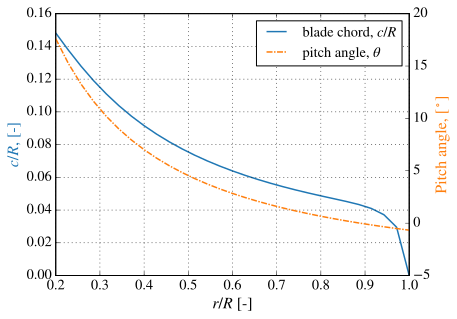

In [123]:
σCL_factor = 2.0 * np.pi / ( Z * CL )

θ_vec = dti.ϕ_vec - α
cR_vec = dti.σCL_vec * σCL_factor *  dti.λ_vec / dti.λ_tip
rR_vec = dti.λ_vec / dti.λ_tip

ax1 = mpl.gca()
ax1.plot( rR_vec, cR_vec, mut.linecolors[0], label=r"blade chord, $c/R$" )
ax1.set_ylabel( r"$c/R$, [-]", color=mut.linecolors[0] )
ax1.set_xlabel( r"$r/R$ [-]")
ax1.grid()
# ax1.set_ylim( 0, 0.25 )

ax2 = mpl.gca().twinx()
ax2.plot( rR_vec, θ_vec * rad2deg, mut.linecolors[1], \
          dashes=mut.linestyles[2], label=r'pitch angle, $\theta$' )
ax2.tick_params(axis='y' )
ax2.set_ylabel( r"Pitch angle, [$^\circ$]", color=mut.linecolors[1] )
# ax2.set_ylim( 0, 50 )
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right' )

mpl.savefig( "TurbineBlade.pdf" )

In [116]:
def tip_loss( a, ap, ϕ, λ, λtip ):
    # ff = 0.5 * Z * ( λtip / λ - 1 ) * np.sqrt( 1 + ( λ / (1-a) )**2 )
    # rr =  np.max( ( 2.0 / np.pi * np.arccos( np.exp( -ff ) ), 1E-3 ) )
    # rr = 1

    ff = Z * λtip / ( λ * np.tan( ϕ ) ) - 0.5
    rr =  2.0 / np.pi * np.arccos( np.cosh( λ / λtip * ff ) / np.cosh( ff ) )
    return rr

In [117]:
dtv = dti

for i, λ in enumerate( dtv.λ_vec ):

    a = dtv.a_vec[i]
    ap = dtv.ap_vec[i]
    σ = dtv.σCL_vec[i] / CL

    for j in range( 30 ):

        ϕ = np.atan2( ( 1 - a ), ( 1 + ap ) * λ )
        cosϕ = np.cos( ϕ )
        sinϕ = np.sin( ϕ )

        Ca = CL * cosϕ + CD * sinϕ
        Ct = CL * sinϕ - CD * cosϕ

        a  = σ * Ca / ( 4 * sinϕ**2 + σ * Ca )
        ap = σ * Ct / ( 4 * sinϕ*cosϕ - σ * Ct )

    k = tip_loss( a, ap, ϕ, λ, dtv.λ_tip )

    dtv.a_vec[i] = a
    dtv.ap_vec[i] = ap
    dtv.σCL_vec[i] = dti.σCL_vec[i] * k

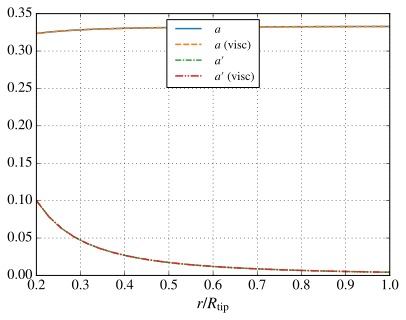

In [118]:
rR_vec = dtv.λ_vec / dtv.λ_tip

mpl.plot( rR_vec, dti.a_vec,  label = r"$a$" )
mpl.plot( rR_vec, dtv.a_vec,  label = r"$a$ (visc)" )
mpl.plot( rR_vec, dti.ap_vec, label = r"$a\prime$" )
mpl.plot( rR_vec, dtv.ap_vec, label = r"$a\prime$ (visc)" )
# mpl.plot( rR_vec, visc_k_vec, label = r"$k$" )

mpl.xlabel( r"$r/R_\mathrm{tip}$")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()
# mpl.ylim( ( 0.0, 1.05 ) )
mpl.savefig( "InductionFactors.pdf" )

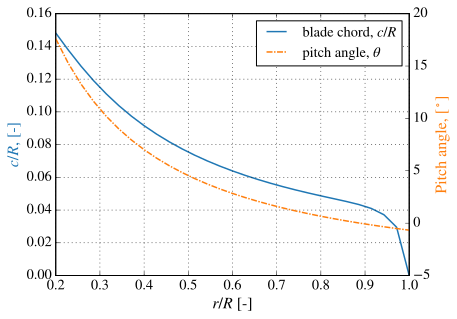

In [121]:
θ_vec = dtv.ϕ_vec - α
cR_vec = dtv.σCL_vec * σCL_factor *  dtv.λ_vec / dtv.λ_tip
rR_vec = dtv.λ_vec / dtv.λ_tip

mpl.figure(4)
ax1 = mpl.gca()
ax1.plot( rR_vec, cR_vec, mut.linecolors[0], label=r"blade chord, $c/R$" )
ax1.set_ylabel( r"$c/R$, [-]", color=mut.linecolors[0] )
ax1.set_xlabel( r"$r/R$ [-]")
ax1.grid()
# ax1.set_ylim( 0, 0.25 )

ax2 = mpl.gca().twinx()
ax2.plot( rR_vec, θ_vec * rad2deg, mut.linecolors[1], \
          dashes=mut.linestyles[2], label=r'pitch angle, $\theta$' )
ax2.tick_params(axis='y' )
ax2.set_ylabel( r"Pitch angle, [$^\circ$]", color=mut.linecolors[1] )
# ax2.set_ylim( 0, 50 )
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right' )

mpl.savefig( "TurbineBlade_visc.pdf" )

In [120]:
df = pd.DataFrame( { r"$\lambda$": dtv.λ_vec,
                     r"$a$": dtv.a_vec,
                     r"$a'$": dtv.ap_vec,
                     r"$\phi$": dtv.ϕ_vec*rad2deg,
                     r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$": dtv.σCL_vec*dtv.λ_vec,
                     r"$\sigma C_L$": dtv.σCL_vec
                    } )

# print( df.to_latex(index=False,
#        formatters=["{:.2f}".format,"{:.5f}".format,"{:.5f}".format, \
#                    "{:.2f}".format,"{:.3f}".format,"{:.4f}".format]
# ))
df

,$\lambda$,$a$,$a'$,$\phi$,"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$",$\sigma C_L$
0,1.4,0.323473,0.100022,23.691785,0.471967,0.337119
1,1.6,0.325398,0.078267,21.336922,0.438676,0.274172
2,1.8,0.326832,0.062799,19.369736,0.407535,0.226408
3,2.0,0.327922,0.051433,17.710034,0.379134,0.189567
4,2.2,0.328768,0.042851,16.295970,0.353540,0.160700
5,2.4,0.329434,0.036221,15.079910,0.330586,0.137744
6,2.6,0.329968,0.030999,14.025007,0.310024,0.119240
7,2.8,0.330401,0.026814,13.102549,0.291582,0.104136
8,3.0,0.330757,0.023413,12.289966,0.275006,0.091669
9,3.2,0.331053,0.020611,11.569350,0.260062,0.081269
